In [20]:
import os
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, CatBoostRegressor
import shap
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

import matplotlib.pyplot as plt

pd.options.display.max_rows = 5000
pd.options.display.max_columns = 100

# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

%matplotlib inline

shap.initjs()

In [21]:
def plot_tree(tree):
    dot_data = StringIO()
    export_graphviz(dt, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    return Image(graph.create_png())

In [25]:
X,y = shap.datasets.adult()

# create a train/test split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.6, random_state=7)
X_test, X_valid, y_test, y_valid = train_test_split(X_valid, y_valid, test_size=0.5, random_state=7)
del X, y

In [26]:
X_train.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
18857,26.0,2,13.0,4,13,3,4,1,0.0,0.0,40.0,39
6964,29.0,4,16.0,2,10,4,1,1,0.0,0.0,60.0,19
21495,41.0,4,9.0,2,3,4,4,1,0.0,0.0,45.0,39
16208,41.0,2,13.0,0,10,0,4,1,0.0,0.0,20.0,39
10995,20.0,0,10.0,4,0,0,4,1,0.0,0.0,40.0,39


### XGB

In [30]:
%%time
params = {
    'learning_rate': .01,
    'max_depth': 7,
    'min_child_weight': 3,
    'subsample': .8,
    'colsample_bytree': .8,
    'reg_lambda': .05,
    'reg_alpha': .025,
    'gamma': .1,
    'random_state': 0
}
xgb = XGBClassifier(**params)
xgb.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test), (X_valid, y_valid)],
        eval_metric='auc',
        early_stopping_rounds=20)

[0]	validation_0-merror:0.804208	validation_1-merror:0.855037	validation_2-merror:0.860272
Multiple eval metrics have been passed: 'validation_2-merror' will be used for early stopping.

Will train until validation_2-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.790848	validation_1-merror:0.851863	validation_2-merror:0.857406
[2]	validation_0-merror:0.774416	validation_1-merror:0.859234	validation_2-merror:0.857304
[3]	validation_0-merror:0.763437	validation_1-merror:0.855753	validation_2-merror:0.856485
[4]	validation_0-merror:0.756373	validation_1-merror:0.853808	validation_2-merror:0.857918
[5]	validation_0-merror:0.749616	validation_1-merror:0.853808	validation_2-merror:0.860375
[6]	validation_0-merror:0.748311	validation_1-merror:0.852068	validation_2-merror:0.85976
[7]	validation_0-merror:0.743243	validation_1-merror:0.852682	validation_2-merror:0.859965
[8]	validation_0-merror:0.736333	validation_1-merror:0.853808	validation_2-merror:0.860068
[9]	validation_0-me

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.1,
              learning_rate=0.01, max_delta_step=0, max_depth=7,
              min_child_weight=3, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0.025, reg_lambda=0.05, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [31]:
%%time
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

CPU times: user 8.88 s, sys: 11.9 ms, total: 8.89 s
Wall time: 8.9 s


In [7]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

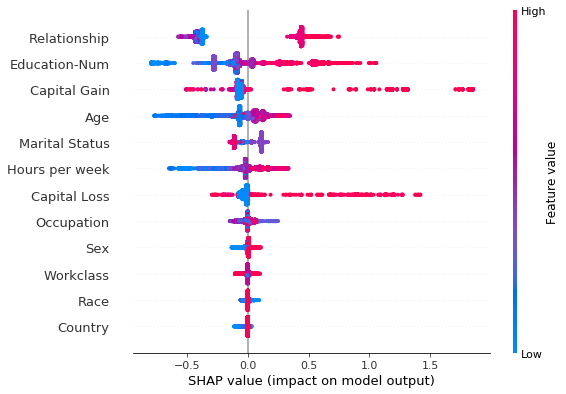

CPU times: user 2.39 s, sys: 512 ms, total: 2.91 s
Wall time: 1.67 s


In [13]:
%%time
shap.summary_plot(shap_values_aprox, X_test)

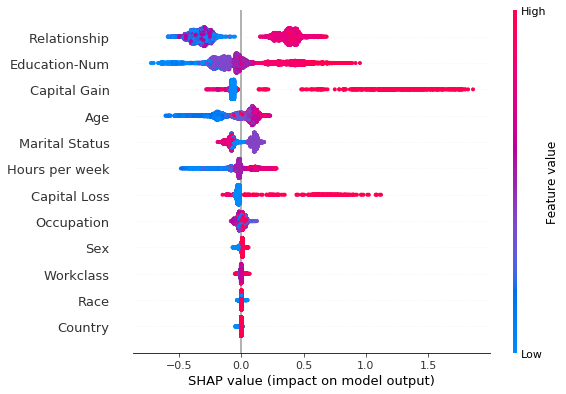

CPU times: user 2.66 s, sys: 543 ms, total: 3.21 s
Wall time: 1.88 s


In [14]:
%%time
shap.summary_plot(shap_values, X_test)

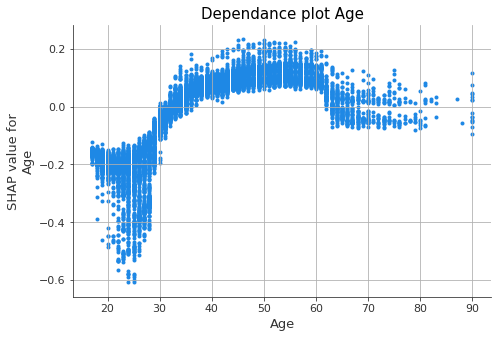

In [9]:
shap.dependence_plot("Age", shap_values, X_test, interaction_index=None, show=False)
plt.title('Dependance plot Age', fontsize=15)
plt.grid()

### LGBM

In [127]:
%%time
cat_feature = ['Workclass', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Country']
params = {
    'learning_rate': .001,
    'max_depth': 7,
    'min_child_weight': 3,
    'subsample': .8,
    'colsample_bytree': .8,
    'reg_lambda': .05,
    'reg_alpha': .025,
    'gamma': .1,
    'random_state': 0
}
lgbm = LGBMClassifier(**params)
lgbm.fit(X_train, y_train,
         eval_set=[(X_train, y_train), (X_test, y_test), (X_valid, y_valid)],
         eval_metric='auc',
         categorical_feature=cat_feature,
         early_stopping_rounds=20)

[1]	training's auc: 0.903604	training's binary_logloss: 0.551885	valid_1's auc: 0.892212	valid_1's binary_logloss: 0.551347	valid_2's auc: 0.897502	valid_2's binary_logloss: 0.551517
Training until validation scores don't improve for 20 rounds
[2]	training's auc: 0.907039	training's binary_logloss: 0.551426	valid_1's auc: 0.893999	valid_1's binary_logloss: 0.550905	valid_2's auc: 0.898773	valid_2's binary_logloss: 0.551068
[3]	training's auc: 0.907797	training's binary_logloss: 0.550969	valid_1's auc: 0.895359	valid_1's binary_logloss: 0.550464	valid_2's auc: 0.899737	valid_2's binary_logloss: 0.550621
[4]	training's auc: 0.914821	training's binary_logloss: 0.550526	valid_1's auc: 0.90553	valid_1's binary_logloss: 0.550036	valid_2's auc: 0.908979	valid_2's binary_logloss: 0.550184
[5]	training's auc: 0.915443	training's binary_logloss: 0.550085	valid_1's auc: 0.906955	valid_1's binary_logloss: 0.549608	valid_2's auc: 0.910229	valid_2's binary_logloss: 0.549748
[6]	training's auc: 0.915

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
               gamma=0.1, importance_type='split', is_unbalance=False,
               learning_rate=0.001, max_cat_to_onehot=5, max_depth=7,
               min_child_samples=20, min_child_weight=3, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=0, reg_alpha=0.025, reg_lambda=0.05, silent=True,
               subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

In [11]:
%%time
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_test)[1]

CPU times: user 6.81 s, sys: 19 ms, total: 6.83 s
Wall time: 6.84 s


/home/qraquet/Documents/Notebooks/shap/lib/python3.6/site-packages/shap/explainers/tree.py:195: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


In [12]:
shap.force_plot(explainer.expected_value[1], shap_values[0,:], X_test.iloc[0,:])

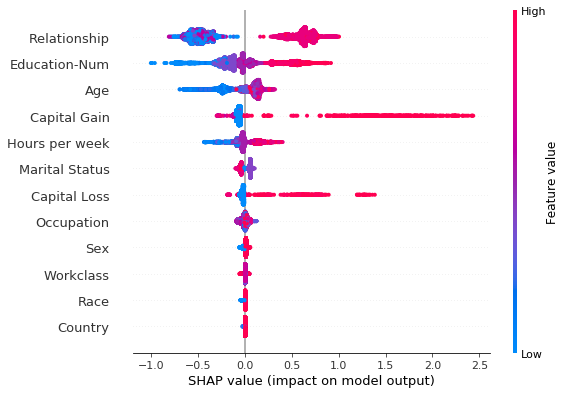

CPU times: user 2.36 s, sys: 665 ms, total: 3.03 s
Wall time: 1.69 s


In [13]:
%%time
shap.summary_plot(shap_values, X_test)

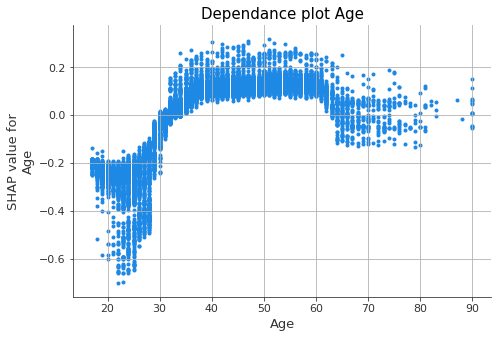

In [14]:
shap.dependence_plot("Age", shap_values, X_test, interaction_index=None, show=False)
plt.title('Dependance plot Age', fontsize=15)
plt.grid()

### CatBoost

In [15]:
%%time
params = {
    'learning_rate': .01,
    'max_depth': 7,
    'colsample_bylevel': .8,
    'reg_lambda': .05,
    'eval_metric': 'AUC',
}
cb = CatBoostClassifier(**params)
cb.fit(X_train, y_train*1.0,
         #eval_set=[(X_train, y_train*1.0), (X_valid, y_valid*1.0)],
         early_stopping_rounds=20)

0:	total: 91.8ms	remaining: 1m 31s
1:	total: 108ms	remaining: 53.7s
2:	total: 124ms	remaining: 41.3s
3:	total: 141ms	remaining: 35s
4:	total: 156ms	remaining: 31s
5:	total: 171ms	remaining: 28.3s
6:	total: 186ms	remaining: 26.4s
7:	total: 201ms	remaining: 24.9s
8:	total: 216ms	remaining: 23.8s
9:	total: 231ms	remaining: 22.9s
10:	total: 244ms	remaining: 22s
11:	total: 262ms	remaining: 21.6s
12:	total: 278ms	remaining: 21.1s
13:	total: 299ms	remaining: 21.1s
14:	total: 322ms	remaining: 21.2s
15:	total: 342ms	remaining: 21s
16:	total: 357ms	remaining: 20.6s
17:	total: 373ms	remaining: 20.4s
18:	total: 390ms	remaining: 20.1s
19:	total: 403ms	remaining: 19.7s
20:	total: 421ms	remaining: 19.6s
21:	total: 434ms	remaining: 19.3s
22:	total: 449ms	remaining: 19.1s
23:	total: 464ms	remaining: 18.9s
24:	total: 479ms	remaining: 18.7s
25:	total: 494ms	remaining: 18.5s
26:	total: 521ms	remaining: 18.8s
27:	total: 547ms	remaining: 19s
28:	total: 567ms	remaining: 19s
29:	total: 590ms	remaining: 19.1s


240:	total: 4.1s	remaining: 12.9s
241:	total: 4.11s	remaining: 12.9s
242:	total: 4.13s	remaining: 12.9s
243:	total: 4.14s	remaining: 12.8s
244:	total: 4.16s	remaining: 12.8s
245:	total: 4.17s	remaining: 12.8s
246:	total: 4.19s	remaining: 12.8s
247:	total: 4.21s	remaining: 12.8s
248:	total: 4.22s	remaining: 12.7s
249:	total: 4.24s	remaining: 12.7s
250:	total: 4.25s	remaining: 12.7s
251:	total: 4.27s	remaining: 12.7s
252:	total: 4.29s	remaining: 12.7s
253:	total: 4.3s	remaining: 12.6s
254:	total: 4.32s	remaining: 12.6s
255:	total: 4.33s	remaining: 12.6s
256:	total: 4.35s	remaining: 12.6s
257:	total: 4.37s	remaining: 12.6s
258:	total: 4.38s	remaining: 12.5s
259:	total: 4.39s	remaining: 12.5s
260:	total: 4.41s	remaining: 12.5s
261:	total: 4.42s	remaining: 12.5s
262:	total: 4.44s	remaining: 12.4s
263:	total: 4.46s	remaining: 12.4s
264:	total: 4.48s	remaining: 12.4s
265:	total: 4.49s	remaining: 12.4s
266:	total: 4.51s	remaining: 12.4s
267:	total: 4.53s	remaining: 12.4s
268:	total: 4.54s	rema

487:	total: 8.35s	remaining: 8.76s
488:	total: 8.36s	remaining: 8.74s
489:	total: 8.38s	remaining: 8.72s
490:	total: 8.39s	remaining: 8.7s
491:	total: 8.4s	remaining: 8.68s
492:	total: 8.42s	remaining: 8.66s
493:	total: 8.45s	remaining: 8.65s
494:	total: 8.47s	remaining: 8.64s
495:	total: 8.49s	remaining: 8.63s
496:	total: 8.51s	remaining: 8.62s
497:	total: 8.54s	remaining: 8.61s
498:	total: 8.57s	remaining: 8.6s
499:	total: 8.59s	remaining: 8.59s
500:	total: 8.61s	remaining: 8.58s
501:	total: 8.64s	remaining: 8.57s
502:	total: 8.66s	remaining: 8.56s
503:	total: 8.68s	remaining: 8.54s
504:	total: 8.7s	remaining: 8.52s
505:	total: 8.72s	remaining: 8.51s
506:	total: 8.74s	remaining: 8.5s
507:	total: 8.78s	remaining: 8.5s
508:	total: 8.81s	remaining: 8.5s
509:	total: 8.86s	remaining: 8.51s
510:	total: 8.9s	remaining: 8.52s
511:	total: 8.93s	remaining: 8.52s
512:	total: 8.99s	remaining: 8.54s
513:	total: 9.04s	remaining: 8.55s
514:	total: 9.08s	remaining: 8.55s
515:	total: 9.11s	remaining:

729:	total: 13.4s	remaining: 4.95s
730:	total: 13.4s	remaining: 4.94s
731:	total: 13.5s	remaining: 4.93s
732:	total: 13.5s	remaining: 4.92s
733:	total: 13.6s	remaining: 4.91s
734:	total: 13.6s	remaining: 4.9s
735:	total: 13.6s	remaining: 4.89s
736:	total: 13.7s	remaining: 4.88s
737:	total: 13.7s	remaining: 4.87s
738:	total: 13.7s	remaining: 4.85s
739:	total: 13.7s	remaining: 4.83s
740:	total: 13.8s	remaining: 4.81s
741:	total: 13.8s	remaining: 4.79s
742:	total: 13.8s	remaining: 4.77s
743:	total: 13.8s	remaining: 4.75s
744:	total: 13.8s	remaining: 4.73s
745:	total: 13.8s	remaining: 4.71s
746:	total: 13.9s	remaining: 4.69s
747:	total: 13.9s	remaining: 4.67s
748:	total: 13.9s	remaining: 4.65s
749:	total: 13.9s	remaining: 4.63s
750:	total: 13.9s	remaining: 4.61s
751:	total: 13.9s	remaining: 4.59s
752:	total: 13.9s	remaining: 4.57s
753:	total: 13.9s	remaining: 4.55s
754:	total: 14s	remaining: 4.54s
755:	total: 14s	remaining: 4.52s
756:	total: 14s	remaining: 4.5s
757:	total: 14s	remaining: 4

967:	total: 18.7s	remaining: 620ms
968:	total: 18.8s	remaining: 600ms
969:	total: 18.8s	remaining: 581ms
970:	total: 18.8s	remaining: 561ms
971:	total: 18.8s	remaining: 542ms
972:	total: 18.8s	remaining: 523ms
973:	total: 18.8s	remaining: 503ms
974:	total: 18.9s	remaining: 484ms
975:	total: 18.9s	remaining: 464ms
976:	total: 18.9s	remaining: 445ms
977:	total: 18.9s	remaining: 426ms
978:	total: 19s	remaining: 407ms
979:	total: 19s	remaining: 388ms
980:	total: 19.1s	remaining: 369ms
981:	total: 19.1s	remaining: 351ms
982:	total: 19.2s	remaining: 331ms
983:	total: 19.2s	remaining: 312ms
984:	total: 19.2s	remaining: 293ms
985:	total: 19.2s	remaining: 273ms
986:	total: 19.3s	remaining: 254ms
987:	total: 19.3s	remaining: 234ms
988:	total: 19.3s	remaining: 214ms
989:	total: 19.3s	remaining: 195ms
990:	total: 19.3s	remaining: 175ms
991:	total: 19.3s	remaining: 156ms
992:	total: 19.4s	remaining: 136ms
993:	total: 19.4s	remaining: 117ms
994:	total: 19.4s	remaining: 97.5ms
995:	total: 19.4s	remai

In [16]:
%%time
explainer = shap.TreeExplainer(cb)
shap_values = explainer.shap_values(X_test)

CPU times: user 7.37 s, sys: 117 ms, total: 7.49 s
Wall time: 1.6 s


In [17]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

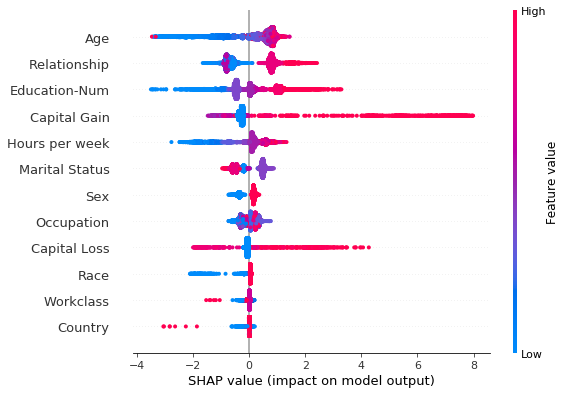

CPU times: user 3.2 s, sys: 923 ms, total: 4.12 s
Wall time: 2.3 s


In [18]:
%%time
shap.summary_plot(shap_values, X_test)

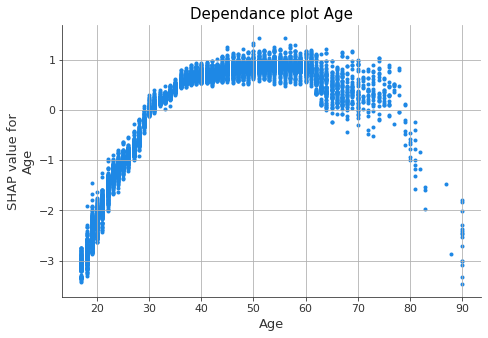

In [19]:
shap.dependence_plot("Age", shap_values, X_test, interaction_index=None, show=False)
plt.title('Dependance plot Age', fontsize=15)
plt.grid()

### Experiment with single tree

In [164]:
np.random.seed(0)
sample_size = 1000
ratio = 0.5
n_features = 2

data = np.empty((0, sample_size))
for i in range(n_features):
    data = np.append(data, [np.random.choice([1, 0], sample_size, p=[ratio, 1-ratio])], axis=0)
X = pd.DataFrame(data.T, columns=[f'feature_{i}' for i in range(n_features)])
y = (np.sum(X, axis=1) == n_features)*1

params = {
    'max_depth': n_features,
    'random_state': 0,
}
dt = DecisionTreeClassifier(**params)
dt.fit(X, y)

explainer = shap.TreeExplainer(dt)
shap_values = explainer.shap_values(X)

print(f'mean target {y.mean()}')
print(f'theoretical mean {ratio**n_features}')

mean target 0.248
theoretical mean 0.25


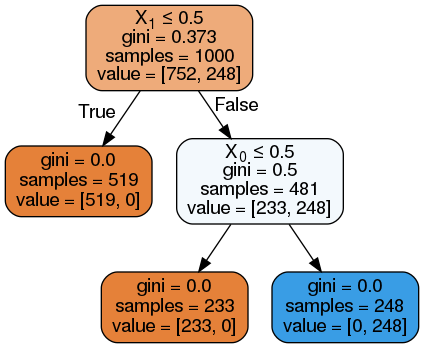

In [165]:
plot_tree(dt)

In [166]:
print(f'gini gain feature 1: {(0.373 - 0.5*(481/1000))/0.373}')
print(f'gini gain feature 0: {(0.5*(481/1000))/0.373}')

gini gain feature 1: 0.3552278820375335
gini gain feature 0: 0.6447721179624665


In [167]:
dt.feature_importances_

array([0.64415889, 0.35584111])

#### Global importance

<BarContainer object of 2 artists>

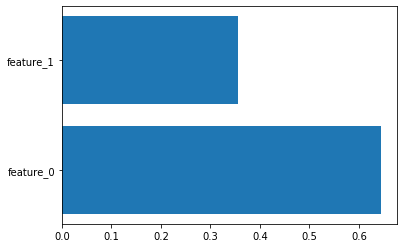

In [168]:
plt.barh(np.arange(n_features), dt.feature_importances_, tick_label=X.columns)

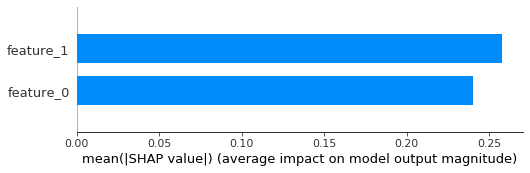

In [169]:
shap.summary_plot(shap_values[1], X, plot_type="bar")

#### Individual importance

In [170]:
i = 0
shap.force_plot(explainer.expected_value[1], shap_values[1][i], X.iloc[i,:])

In [171]:
i = 1
shap.force_plot(explainer.expected_value[1], shap_values[1][i], X.iloc[i,:])

In [172]:
i = 6
shap.force_plot(explainer.expected_value[1], shap_values[1][i], X.iloc[i,:])

In [29]:
i = 4
shap.force_plot(explainer.expected_value[1], shap_values[1][i], X.iloc[i,:])

### Experiment with single tree (correlated features)

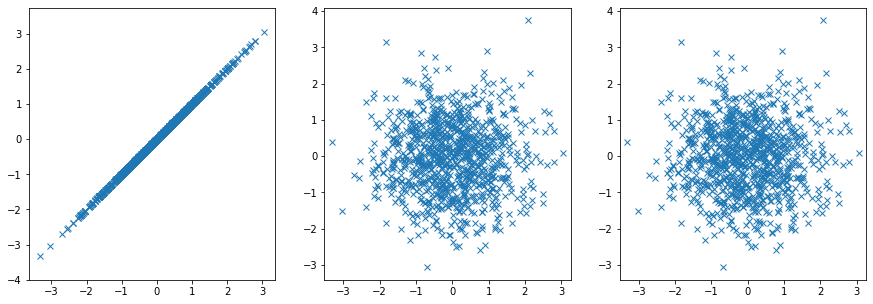

In [222]:
np.random.seed(1)
n_features = 3
sample_size = 1000
corr = 1
mean = [0, 0]
cov = [[1, corr], [corr, 1]]
x1, x2 = np.random.multivariate_normal(mean, cov, sample_size).T
x3 = np.random.normal(0, 1, sample_size)
data = np.vstack((x1, x2, x3)).T
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.plot(x1, x2, 'x')
plt.axis('equal')
plt.subplot(132)
plt.plot(x1, x3, 'x')
plt.axis('equal')
plt.subplot(133)
plt.plot(x2, x3, 'x')
plt.axis('equal')
plt.show()

In [240]:
X = pd.DataFrame(data, columns=[f'feature_{i}' for i in range(n_features)])
y = (np.sum(X, axis=1) + np.random.normal(0, 1, sample_size) > 0)*1

params = {
    'max_depth': 10,
    'random_state': 3,
    'max_features': 2
}
dt = DecisionTreeClassifier(**params)
dt.fit(X, y)

explainer = shap.TreeExplainer(dt)
shap_values = explainer.shap_values(X)

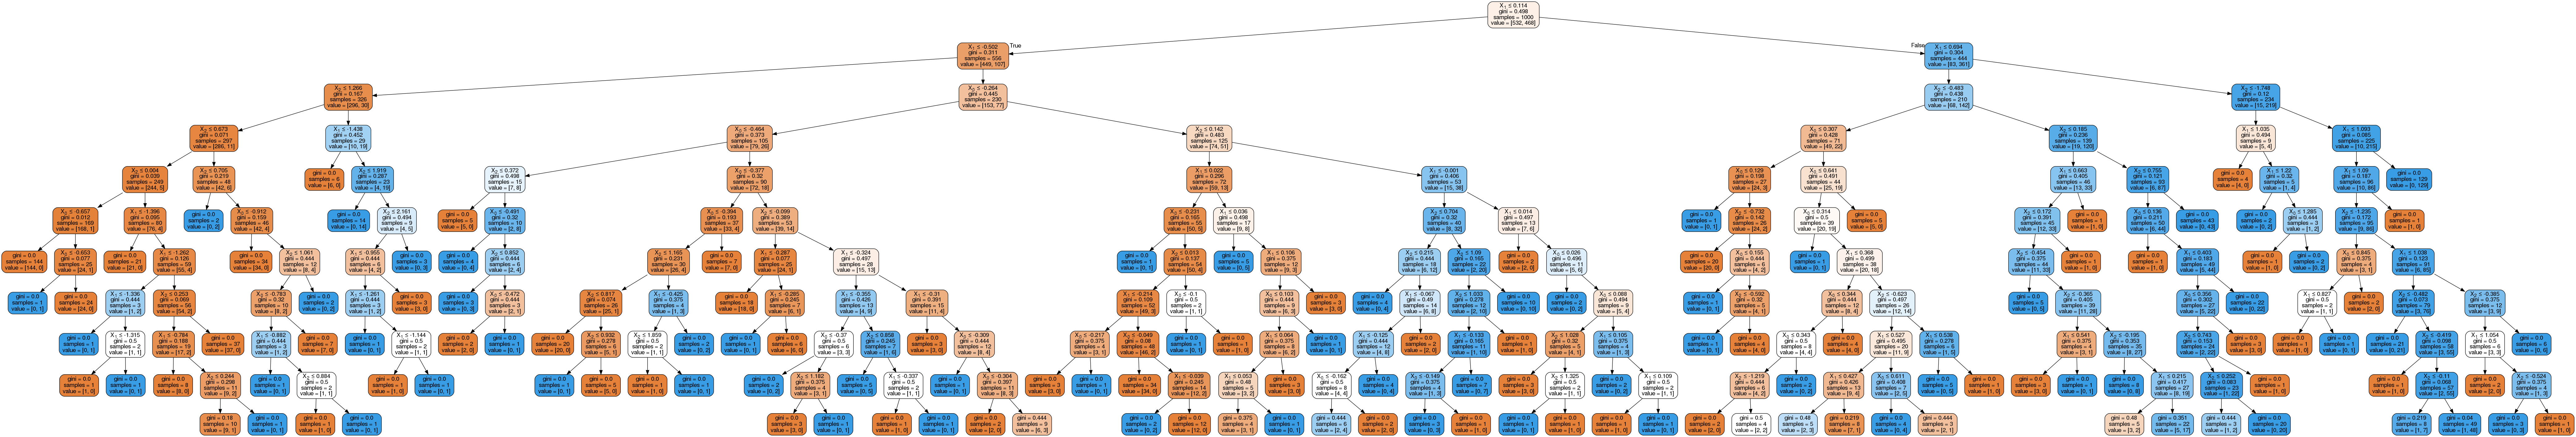

In [241]:
plot_tree(dt)

#### Global importance

<BarContainer object of 3 artists>

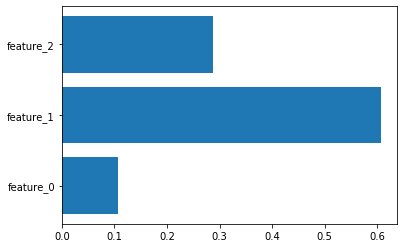

In [242]:
plt.barh(np.arange(n_features), dt.feature_importances_, tick_label=X.columns)

In [243]:
imp = dt.feature_importances_
imp

array([0.10580953, 0.60679252, 0.28739796])

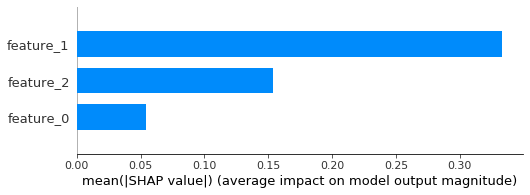

In [244]:
shap.summary_plot(shap_values[1], X, plot_type="bar")

In [245]:
imp = np.mean(np.abs(shap_values[1]), axis=0)
imp /= imp.sum()
imp

array([0.10045172, 0.61578358, 0.2837647 ])

#### Individual importance

In [246]:
i = 2
shap.force_plot(explainer.expected_value[1], shap_values[1][i], X.iloc[i,:])

In [247]:
i = 4
shap.force_plot(explainer.expected_value[1], shap_values[1][i], X.iloc[i,:])

In [248]:
i = 8
shap.force_plot(explainer.expected_value[1], shap_values[1][i], X.iloc[i,:])

In [249]:
i = 10
shap.force_plot(explainer.expected_value[1], shap_values[1][i], X.iloc[i,:])

In [250]:
shap.force_plot(explainer.expected_value[1], shap_values[1], X)

#### Clustering

In [251]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=4, random_state=0)
output = km.fit_predict(shap_values[1]).reshape(-1,1)

In [252]:
X[output==0].mean()

feature_0    1.009990
feature_1    1.009990
feature_2   -0.022197
dtype: float64

In [253]:
X[output==1].mean()

feature_0   -0.874002
feature_1   -0.874002
feature_2   -0.137802
dtype: float64

In [254]:
X[output==2].mean()

feature_0   -0.098266
feature_1   -0.098266
feature_2    1.070089
dtype: float64

In [255]:
X[output==3].mean()

feature_0    0.236337
feature_1    0.236337
feature_2   -1.020176
dtype: float64

#### Interaction values

In [256]:
shap_interaction_values = explainer.shap_interaction_values(X)
main_effect = shap_interaction_values[1].diagonal(axis1=1, axis2=2)

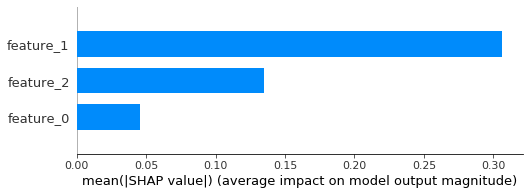

In [257]:
shap.summary_plot(main_effect, X, plot_type="bar")

In [260]:
imp = np.mean(np.abs(main_effect), axis=0)
imp /= imp.sum()
imp

array([0.09327401, 0.62944639, 0.2772796 ])